# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [5]:
import pickle
def list_to_pickle(filename, listname):
    open_file = open(filename, "wb")
    pickle.dump(listname, open_file)
    open_file.close()

def list_from_pickle(filename):
    open_file = open(filename, "rb")
    loaded_list = pickle.load(open_file)
    open_file.close()
    return loaded_list

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

In [66]:
# 분석용 데이터 입력
stock_name = 'sec'
directory_for_ml = '../data/data_for_ml/'
fname = f'df_{stock_name}_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title ='sec'

In [67]:
df.drop(columns=['value', 'r_open_high_5', 'close_cr_5', 'r_open_high_1'], inplace=True )

In [68]:
new_columns = ['kospi_cr', 'krw_cr', 'corporateetc', 'dxy_cr', 'open', 'retail', 'bond_usa_10_cr', 'spx_cr', 'spx_f_cr', 'bond_kor_10_cr', 'close_cr_1']

In [69]:
df_new = df[new_columns]

In [70]:
data = df_new.iloc[:240, :-1]
data_test = df_new.iloc[240:, :-1]
target = df_new.iloc[:240, -1]
# df_sel.tail()
# df_test.head()

In [71]:
train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

In [72]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)
data_test_scaled = ss.transform(data_test)

### 인공신경망

0. feature 갯수 최적화 (?) 수렴이나 overfit 방지?
1. train이 수렴할 정도로 model 구성
2. train 수렴과 overfit이 관계가 있나?

In [73]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(inp_num,)))
#     model.add(Dropout(0.1))
    model.add(Dense(6, activation='sigmoid'))
#     model.add(Dropout(0.1))
    model.add(Dense(3, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [74]:
d_rate = 1e-7 # default value
adam_custom = tf.keras.optimizers.Adam(
    learning_rate=0.000005, # default  0.001 , best fit 0.0001 for skhinix
    beta_1=0.9, beta_2=0.999, epsilon=d_rate, amsgrad=False,  # default
    weight_decay=None, clipnorm=None, clipvalue=None, global_clipnorm=None, use_ema=False, ema_momentum=0.99,
    ema_overwrite_frequency=None, jit_compile=True, name='Adam' )

In [75]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    model = None
except:
    pass

model = model_fn(len(data.columns))
# model.compile(optimizer='adam', loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer=adam_custom , loss='binary_crossentropy', 
              metrics=['accuracy'])
# model.summary()

In [76]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath='best_model/best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
     save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', save_best_only=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=200, monitor='val_loss', mode='min', restore_best_weights=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

reducelr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.9,  
                                                patience=100, verbose=0, mode='auto', min_delta=0.0001, #0.0001
                                                cooldown=0, min_lr=0 )

def scheduler(epoch, lr):
    if epoch < 1000:
        print("epoch, m, lr", epoch, m, lr)
        return lr
    else:
        print("epoch, m, lr", epoch, m, lr)
        return lr * tf.math.exp(-0.01)

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [77]:
history = model.fit(train_scaled, train_target, epochs=30000, verbose=0, batch_size=20,
#                     callbacks=[checkpoint_cb, earlystopping_cb, reducelr],
                    callbacks=[earlystopping_cb, reducelr],
                    validation_data=(test_scaled, test_target))

# loss 가 최저로 내려가지 않거나 큰 상태에서 머무르면 adam (optimizer)의 learning rate를 줄이면서 loss가 작아지는지 시도해 볼 것
# batch size 도 조절
# layer를 추가하면서 진행도 많이 도움됨.(mobis 경우에 적용) -> 과대적합이 됨.
# batch_size를 늘리거나 줄이면 val_loss의 꺽이는 영역이 위아래로 바뀌니 lr을 고정하고 조금씩 조정하면서 최적의 사이즈를 찾아야 함.
# --> 이후 lr을 아주 조금씩 줄이면서 시도함. (0.0001 -> 0.00009 -> 0.00008 )

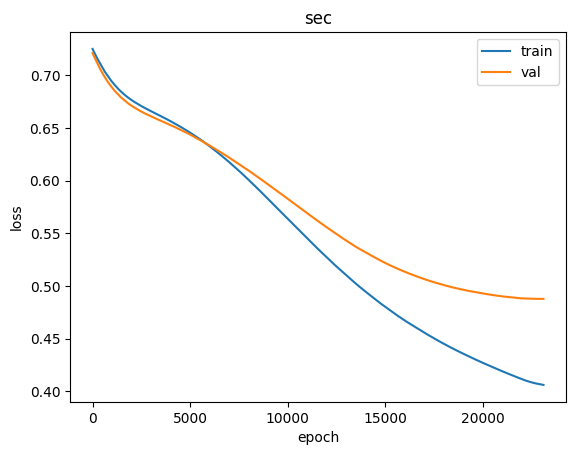

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title)
plt.show()

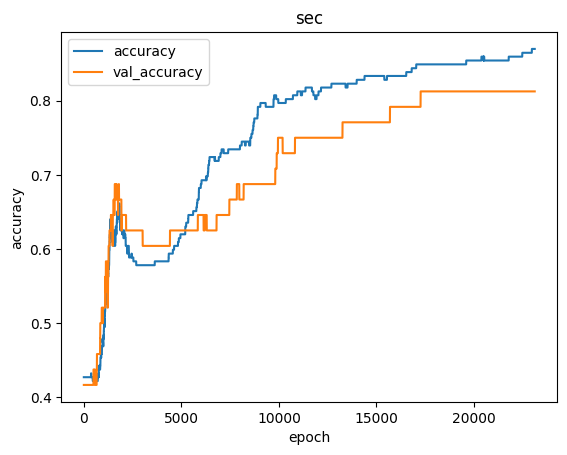

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title)
plt.show()

In [80]:
# 정밀도 : 양성으로 예측된 것(TP+FP) 중 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
model.evaluate(test_scaled, test_target)
y_predict = model.predict(np.array(test_scaled))
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]
print("정밀도", precision_score(test_target, y_predict_list)) 
print("재현율", recall_score(test_target, y_predict_list))
print("f1_acore", f1_score(test_target, y_predict_list))
print("roc_auc_score", roc_auc_score(test_target, y_predict_list))

print("confusion matrix", confusion_matrix(test_target, y_predict_list))

2/2 [==============================] - 0s 2ms/step
정밀도 0.7894736842105263
재현율 0.75
f1_acore 0.7692307692307692
roc_auc_score 0.8035714285714286
confusion matrix [[24  4]
 [ 5 15]]


In [81]:
data_test_target = df_new.iloc[240:, -1]
model.evaluate(data_test_scaled, data_test_target)
y_predict = model.predict(np.array(data_test_scaled))
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]
print("정밀도", precision_score(data_test_target, y_predict_list)) 
print("재현율", recall_score(data_test_target, y_predict_list))
print("f1_acore", f1_score(data_test_target, y_predict_list))
print("roc_auc_score", roc_auc_score(data_test_target, y_predict_list))

print("confusion matrix", confusion_matrix(data_test_target, y_predict_list))

1/1 [==============================] - 0s 15ms/step
정밀도 1.0
재현율 0.6875
f1_acore 0.8148148148148148
roc_auc_score 0.84375
confusion matrix [[12  0]
 [ 5 11]]


In [82]:
compare = [ [x, y] for x, y in zip(data_test_target, y_predict)]
# compare = [ [x, y] for x, y in zip(test_target, y_predict_list)]
compare # 실제값. 예측값

[[0, array([0.3367064], dtype=float32)],
 [1, array([0.7426586], dtype=float32)],
 [1, array([0.5612608], dtype=float32)],
 [1, array([0.76346767], dtype=float32)],
 [1, array([0.7597178], dtype=float32)],
 [1, array([0.4982327], dtype=float32)],
 [0, array([0.13982785], dtype=float32)],
 [0, array([0.13967623], dtype=float32)],
 [1, array([0.7725481], dtype=float32)],
 [1, array([0.66395986], dtype=float32)],
 [1, array([0.23308164], dtype=float32)],
 [0, array([0.13436125], dtype=float32)],
 [1, array([0.6942699], dtype=float32)],
 [1, array([0.75925684], dtype=float32)],
 [0, array([0.25375473], dtype=float32)],
 [0, array([0.14842649], dtype=float32)],
 [1, array([0.14123891], dtype=float32)],
 [1, array([0.6767369], dtype=float32)],
 [0, array([0.1348637], dtype=float32)],
 [1, array([0.7649683], dtype=float32)],
 [0, array([0.13668679], dtype=float32)],
 [0, array([0.3180636], dtype=float32)],
 [0, array([0.13516393], dtype=float32)],
 [1, array([0.7734346], dtype=float32)],
 [0,

In [83]:
df_new.iloc[240:, -1]

2023-01-18    0
2023-01-19    1
2023-01-20    1
2023-01-25    1
2023-01-26    1
2023-01-27    1
2023-01-30    0
2023-01-31    0
2023-02-01    1
2023-02-02    1
2023-02-03    1
2023-02-06    0
2023-02-07    1
2023-02-08    1
2023-02-09    0
2023-02-10    0
2023-02-13    1
2023-02-14    1
2023-02-15    0
2023-02-16    1
2023-02-17    0
2023-02-21    0
2023-02-22    0
2023-02-23    1
2023-02-24    0
2023-02-27    0
2023-02-28    1
2023-03-02    1
Name: close_cr_1, dtype: int64

In [61]:
data_test_scaled

array([[-3.50784510e-01,  2.77703792e-02, -8.90450586e-02,
        -9.37081310e-02, -1.12206335e-01, -1.08605319e-02,
        -1.86273202e+00, -9.96408142e-01, -1.02419784e+00,
        -1.57586626e+00],
       [ 4.84281449e-01, -6.74190130e-01, -5.26381823e-02,
        -4.94643199e-01, -5.46781386e-01, -1.36066940e-01,
         2.37554273e-01, -4.82961112e-01, -4.91334724e-01,
        -2.08727297e+00],
       [ 5.86534423e-01, -4.20289520e-01, -7.28550355e-02,
        -1.27119387e-01, -2.22772086e-01, -4.28606200e-01,
         8.66536684e-01,  1.21783217e+00,  1.21772625e+00,
         1.09836466e+00],
       [ 1.23413660e+00, -1.70356108e-02, -7.82411033e-02,
        -4.61231943e-01,  1.75391190e+00,  1.14154663e-02,
        -7.87760622e-02, -8.02260984e-03, -3.95992028e-03,
        -6.96885977e-01],
       [ 1.45568471e+00, -1.06647591e-01, -8.05193234e-02,
         3.23932564e-01,  1.49457392e+00,  3.50610575e-01,
         5.46528089e-01,  7.10803232e-01,  7.10856459e-01,
         9.

In [59]:
earlystopping_cb.stopped_epoch

0

In [ ]:
# model_val = load_model('best_model/best_model_1736-0.26-0.88.h5')
# model_val.evaluate(test_scaled, test_target)

1. 정밀도, f1-score, 
2. confusion matrix ((1,1), (2,2), 두개가 큰 비중이면 good, (1,2)은 틀린것을 맞다라고 구분, (2,1)은 맞는 것을 틀린 것이다 라고 결정하는 항목) 따라서
    (2,2) -> (1,2) -> (1,1)로 확인하고. <br>
    (1,2)가 크면 모델 제외 (정밀도(precision = TP / (TP + FP) )가 높아야 함. 낮으면 손해를 보게 됨.), <br>
    재현율(Recall = TP / (TP + FN) ) 은 손해를 끼치지는 않음.
    
<img src="https://raw.githubusercontent.com/fasthill/My-gist/main/data/picture/confusion_matrix.png" width="800"/> <br>

In [ ]:
def scheduler(epoch, lr):
    m = epoch//500
    return lr * tf.math.exp(-0.05*m)
#     if epoch < 500:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

In [ ]:
scheduler(500, 1)


In [ ]:
m= 1//2
m

In [ ]:
m